## EDA para el monitor 2 - Frankfurt (Alemania)

### Carga dataset y extracción columnas relevantes

In [1]:
import pandas as pd

dir = '../0_Datasets/Learning-Datasets/learnData_monit2_DE.csv'
df = pd.read_csv(dir)

# Imprime las columnas del dataset
print(df.columns)

Index(['id', 'measure_id', 'monitor_id', 'landmark_id', 'landmark_type',
       'dst_ip', 'ping_rtt1', 'ping_rtt2', 'ping_rtt3', 'ping_rtt4',
       'ping_rtt5', 'ping_rtt_avg', 'ping_rtt_std', 'direct_distance_kms',
       'init_time', 'end_time'],
      dtype='object')


In [2]:
# Nos quedamos con las columnas que nos interesan
df_1 = df[[
    'measure_id',
    'monitor_id',
    'landmark_id',
    'landmark_type',
    'dst_ip',
    'ping_rtt1',
    'ping_rtt2',
    'ping_rtt3',
    'ping_rtt4',
    'ping_rtt5',
    'ping_rtt_avg',
    'ping_rtt_std',
    'direct_distance_kms',
    'init_time'
]]

### Añadimos columnas franjas horarias

In [3]:
# Dependiendo del valor de la columna init_time, añadimos nuevas columnas asociandolo a diferentes franjas horarias
# 1. Cada 4 horas -> 00:00, 04:00, 08:00, 12:00, 16:00, 20:00
# 2. Cada 6 horas -> 00:00, 06:00, 12:00, 18:00

# Asegurar que df_1 es una copia independiente para evitar warnings
df_1 = df_1.copy()

# Convertir a datetime (asegurándonos de trabajar sobre una copia)
df_1['init_time'] = pd.to_datetime(df_1['init_time'])

# Obtener la hora de la columna init_time
df_1_hour = df_1['init_time'].dt.hour

# Crear las columnas asociadas a las franjas horarias de manera segura
df_1.loc[:, '4h_time_slot'] = df_1_hour.apply(lambda x: x - x % 4)
df_1.loc[:, '6h_time_slot'] = df_1_hour.apply(lambda x: x - x % 6)

# Mostrar el número de registros por franja horaria
print(df_1['4h_time_slot'].value_counts())
print(df_1['6h_time_slot'].value_counts())

# Mostramos el dataset con las nuevas columnas
df_1.head(5)

4h_time_slot
16    23999
20    23979
12    23627
0     23023
4     22313
8     22179
Name: count, dtype: int64
6h_time_slot
18    35946
12    35659
0     34188
6     33327
Name: count, dtype: int64


,measure_id,monitor_id,landmark_id,landmark_type,dst_ip,ping_rtt1,ping_rtt2,ping_rtt3,ping_rtt4,ping_rtt5,ping_rtt_avg,ping_rtt_std,direct_distance_kms,init_time,4h_time_slot,6h_time_slot
0,95.217.19.69_2024-11-27 13:31:04,monitor_2_Frankfurt am Main_DE,9404,ripe_anchor,95.217.19.69,29.764,30.024,30.169,29.848,29.768,29.9146,0.15830,1530.246007,2024-11-27 13:31:04,12,12
1,45.13.104.153_2024-11-27 13:31:11,monitor_2_Frankfurt am Main_DE,9042,ripe_probe,45.13.104.153,24.065,23.926,24.240,23.946,23.853,24.0060,0.13539,562.333525,2024-11-27 13:31:11,12,12
2,91.248.58.81_2024-11-27 13:31:20,monitor_2_Frankfurt am Main_DE,12208,ripe_probe,91.248.58.81,35.766,36.673,-1.000,-1.000,-1.000,13.8878,18.23601,387.533698,2024-11-27 13:31:20,12,12
3,212.216.126.87_2024-11-27 13:32:12,monitor_2_Frankfurt am Main_DE,11265,ripe_probe,212.216.126.87,25.110,24.613,24.413,24.414,24.749,24.6598,0.25852,628.002556,2024-11-27 13:32:12,12,12
4,31.21.219.185_2024-11-27 13:32:28,monitor_2_Frankfurt am Main_DE,13743,ripe_probe,31.21.219.185,16.280,16.028,16.142,16.320,16.281,16.2102,0.10935,271.476538,2024-11-27 13:32:28,12,12


### Primera visualización de datos

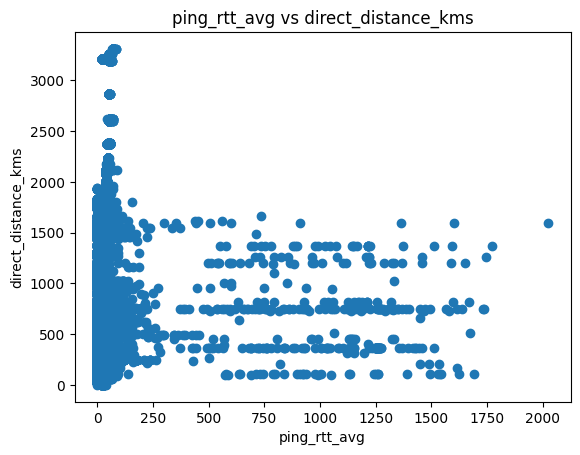

In [4]:
# # Representamos ping_rtt_avg vs direct_distance_kms
import matplotlib.pyplot as plt

plt.scatter(df_1['ping_rtt_avg'], df_1['direct_distance_kms'])
plt.xlabel('ping_rtt_avg')
plt.ylabel('direct_distance_kms')
plt.title('ping_rtt_avg vs direct_distance_kms')
plt.show()

### Primera limpieza a partir de ping y distancia

In [5]:
# Número total de entradas
print(f'Número total de entradas: {len(df_1)}')
# Número de entradas con ping_rtt_avg > 80
print(f'Número de entradas con ping_rtt_avg > 80: {len(df_1[df_1["ping_rtt_avg"] > 80])}')
# Número de entradas con ping_rtt_avg < 0
print(f'Número de entradas con ping_rtt_avg < 0: {len(df_1[df_1["ping_rtt_avg"] < 0])}')
# Número de entradas con direct_distance_kms menor a 50km y ping_rtt_avg mayor a 10
print(f'Número de entradas con direct_distance_kms menor a 50km y ping_rtt_avg mayor a 10: {len(df_1[(df_1["direct_distance_kms"] < 50) & (df_1["ping_rtt_avg"] > 10)])}')

Número total de entradas: 139120
Número de entradas con ping_rtt_avg > 80: 1368
Número de entradas con ping_rtt_avg < 0: 8168
Número de entradas con direct_distance_kms menor a 50km y ping_rtt_avg mayor a 10: 169


Número de entradas tras la limpieza: 129415


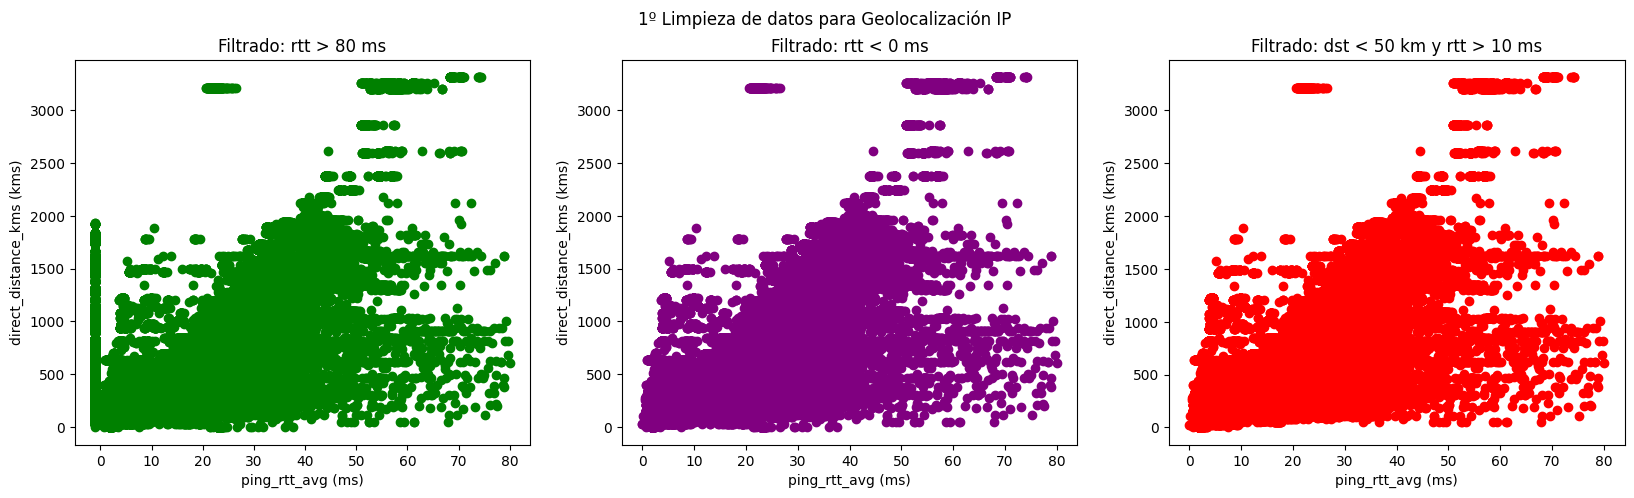

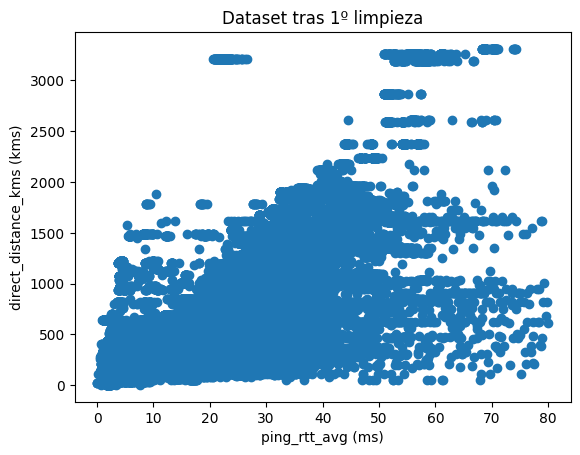

In [6]:
# Creamos una figura con 3 subgráficas
plt.figure(figsize=(20, 5))
plt.suptitle('1º Limpieza de datos para Geolocalización IP')

# Eliminamos aquellas filas con un rtt mayor de 80ms
filtered_data = df_1[df_1['ping_rtt_avg'] < 80]

plt.subplot(1, 3, 1)
plt.scatter(filtered_data['ping_rtt_avg'], filtered_data['direct_distance_kms'], color='green')
plt.xlabel('ping_rtt_avg (ms)')
plt.ylabel('direct_distance_kms (kms)')
plt.title('Filtrado: rtt > 80 ms')

# Eliminamos aquellas filas con un rtt menor a 0 ms
filtered_data = filtered_data[filtered_data['ping_rtt_avg'] > 0]

plt.subplot(1, 3, 2)
plt.scatter(filtered_data['ping_rtt_avg'], filtered_data['direct_distance_kms'], color='purple')
plt.xlabel('ping_rtt_avg (ms)')
plt.ylabel('direct_distance_kms (kms)')
plt.title('Filtrado: rtt < 0 ms')

# Eliminamos aquellas filas con una distancia menor a 50 km y un rtt mayor a 10 ms
filtered_data = filtered_data[~((filtered_data['direct_distance_kms'] < 50) & (filtered_data['ping_rtt_avg'] > 10))]

plt.subplot(1, 3, 3)
plt.scatter(filtered_data['ping_rtt_avg'], filtered_data['direct_distance_kms'], color='red')
plt.xlabel('ping_rtt_avg (ms)')
plt.ylabel('direct_distance_kms (kms)')
plt.title('Filtrado: dst < 50 km y rtt > 10 ms')

# Mostramos el número de entradas tras la limpieza
print(f"Número de entradas tras la limpieza: {filtered_data.shape[0]}")

# Representamos en una gráfica la columna ping_rtt_avg frente a direct_distance_kms
plt.figure()
plt.scatter(filtered_data['ping_rtt_avg'], filtered_data['direct_distance_kms'])
plt.title('Dataset tras 1º limpieza')
plt.xlabel('ping_rtt_avg (ms)')
plt.ylabel('direct_distance_kms (kms)')

# Mostrar las gráficas
plt.show()

### Eliminación de outliers mediante clustering DBSCAN

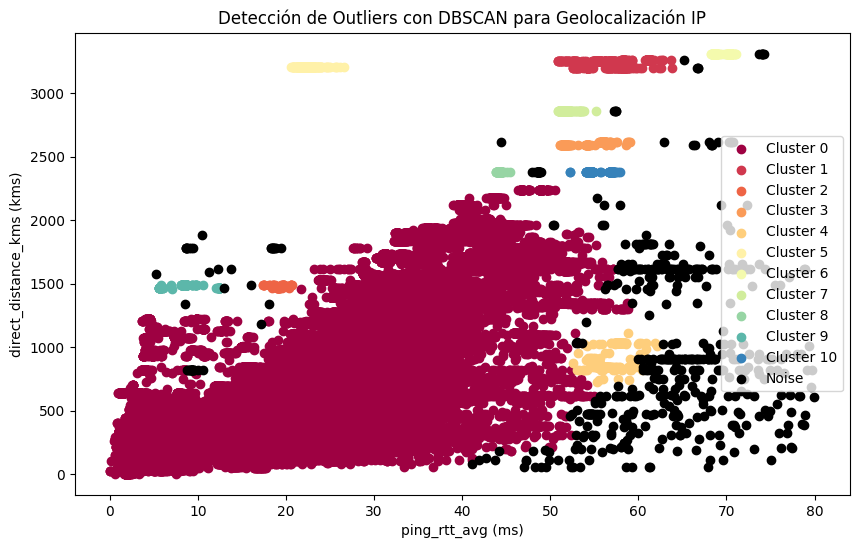

Número de clusters detectados (sin ruido): 11


In [7]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

# Verificamos que el DataFrame tiene las columnas necesarias
if 'ping_rtt_avg' in filtered_data.columns and 'direct_distance_kms' in filtered_data.columns:

    # Escalamos los datos
    scaler = StandardScaler()
    X = filtered_data[['ping_rtt_avg', 'direct_distance_kms']]
    X_scaled = scaler.fit_transform(X)

    # Creamos el modelo DBSCAN
    dbscan = DBSCAN(eps=0.2, min_samples=40)

    # Predecimos los clusters
    clusters = dbscan.fit_predict(X_scaled)

    # Añadimos la columna de clusters al DataFrame
    filtered_data['cluster'] = clusters

    # Obtener número de clusters (excluyendo el ruido)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    # Crear colores para cada cluster
    unique_labels = set(clusters)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    # Representar en una gráfica los clusters detectados
    plt.figure(figsize=(10, 6))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'k'  # Color negro para ruido
        
        class_member_mask = (clusters == k)
        xy = filtered_data[class_member_mask]
        plt.scatter(xy['ping_rtt_avg'], xy['direct_distance_kms'], c=[col], label=f'Cluster {k}' if k != -1 else 'Noise')

    # Añadir etiquetas y título
    plt.xlabel('ping_rtt_avg (ms)')
    plt.ylabel('direct_distance_kms (kms)')
    plt.title('Detección de Outliers con DBSCAN para Geolocalización IP')

    # Añadir la leyenda
    plt.legend()

    # Mostrar la gráfica
    plt.show()

    # Mostrar el número de clusters detectados (sin contar el ruido)
    print(f'Número de clusters detectados (sin ruido): {n_clusters}')
else:
    print("Error: El DataFrame no contiene las columnas necesarias ('ping_rtt_avg' y 'direct_distance_kms').")

Número de entradas antes de eliminar ruido: 129415
Número de entradas después de eliminar ruido: 128855


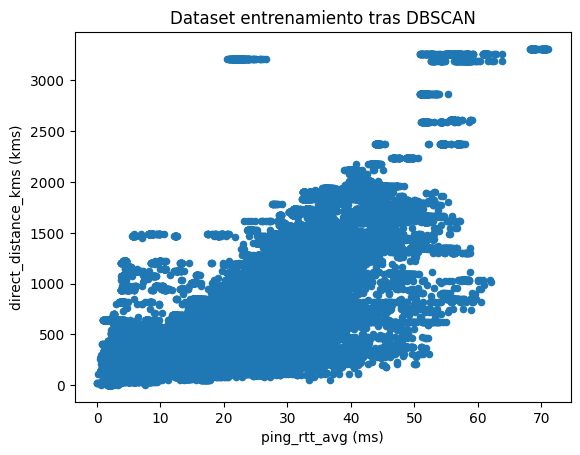

In [8]:
print(f"Número de entradas antes de eliminar ruido: {len(filtered_data)}")

# Eliminamos lo que el clustering ha considerado como ruido
filtered_data2 = filtered_data[filtered_data['cluster'] != -1]

# Eliminamos la columna cluster
filtered_data2 = filtered_data2.drop(columns='cluster')

print(f"Número de entradas después de eliminar ruido: {len(filtered_data2)}")

# Representamos el dataframe
filtered_data2.plot(x='ping_rtt_avg', y='direct_distance_kms', kind='scatter')
plt.title('Dataset entrenamiento tras DBSCAN')
plt.ylabel('direct_distance_kms (kms)')
plt.xlabel('ping_rtt_avg (ms)')
plt.show()

### Mostramos el número de entradas antes vs después y guardamos el dataset

In [9]:
print(f"Número de entradas antes de eliminar ruido: {len(df)}")
print(f"Número de entradas después de eliminar ruido: {len(filtered_data2)}")

Número de entradas antes de eliminar ruido: 139120
Número de entradas después de eliminar ruido: 128855


In [10]:
# Guardamos el dataset limpio en un nuevo archivo CSV
filtered_data2.to_csv('../0_Datasets/Clean-Datasets/learnData_monit2_DE_clean.csv', index=False)